In [1]:
import pandas as pd

df = pd.read_parquet('preprocessed.parquet')

In [2]:
df.shape

(8670130, 11)

In [3]:
df.head()

,Avg Packet Size,Packet Length Mean,Bwd Packet Length Std,Packet Length Variance,Bwd Packet Length Max,Packet Length Max,Packet Length Std,Avg Fwd Segment Size,Fwd Packet Length Mean,Flow Bytes/s,ClassLabel
0,9.00000,6.000000,0.000000,0.000000,0.0,6.0,0.000000,6.00000,6.00000,3.000000e+06,0
1,9.00000,6.000000,0.000000,0.000000,0.0,6.0,0.000000,6.00000,6.00000,1.200000e+07,0
2,9.00000,6.000000,0.000000,0.000000,0.0,6.0,0.000000,6.00000,6.00000,4.000000e+06,0
3,9.00000,6.000000,0.000000,0.000000,0.0,6.0,0.000000,6.00000,6.00000,1.200000e+07,0
4,81.63636,74.833336,119.511505,11562.151367,207.0,233.0,107.527443,69.14286,69.14286,1.474548e+06,0


In [4]:
df.dtypes

Avg Packet Size           float32
Packet Length Mean        float32
Bwd Packet Length Std     float32
Packet Length Variance    float32
Bwd Packet Length Max     float64
Packet Length Max         float64
Packet Length Std         float32
Avg Fwd Segment Size      float32
Fwd Packet Length Mean    float32
Flow Bytes/s              float64
ClassLabel                  int64
dtype: object

In [5]:
min_count = df['ClassLabel'].value_counts().min()
df['ClassLabel'].value_counts(), min_count

(ClassLabel
 0    7186189
 3    1234729
 1     145968
 2     103244
 Name: count, dtype: int64,
 np.int64(103244))

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['ClassLabel'], axis=1)
y = df['ClassLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6069091, 10), (2601039, 10), (6069091,), (2601039,))

In [7]:
type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [8]:
numerical_cols = X.select_dtypes(include='number').columns.tolist()
numerical_cols

['Avg Packet Size',
 'Packet Length Mean',
 'Bwd Packet Length Std',
 'Packet Length Variance',
 'Bwd Packet Length Max',
 'Packet Length Max',
 'Packet Length Std',
 'Avg Fwd Segment Size',
 'Fwd Packet Length Mean',
 'Flow Bytes/s']

In [9]:
from collections import Counter

class_counts = Counter(y_train)

print(class_counts)

# sampling_strategy = {
#     0: class_counts[0] // 2,
#     1: class_counts[1],
#     2: class_counts[2],
#     3: class_counts[3]
# }

sampling_strategy = {
    0: class_counts[2],
    1: class_counts[2],
    2: class_counts[2],
    3: class_counts[2]
}

Counter({0: 5029865, 3: 864704, 1: 102210, 2: 72312})


In [10]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SciPipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

scaling_transformer = SciPipeline(steps=[
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('scaling_transformer', scaling_transformer, numerical_cols),
    ],
    remainder='passthrough'  # ensures other columns, if any, are not dropped
)

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    # ('under', RandomUnderSampler(random_state=69, sampling_strategy=sampling_strategy)),
    ('under', RandomUnderSampler(random_state=69, sampling_strategy='auto')),
    # ('over', SMOTE(random_state=69, sampling_strategy='auto')),
    ('classifier', GaussianNB()),
])

# Define parameter grid for GridSearchCV
param_grid = [
    {
        'classifier': [LGBMClassifier(n_jobs=-1)],
        'classifier__num_leaves': [25, 50],
        'classifier__n_estimators': [25, 50],
        'classifier__learning_rate': [0.1, 0.01]
    },
    {
        'classifier': [XGBClassifier(n_jobs=-1)],
        'classifier__max_depth': [3, 6],
        'classifier__n_estimators': [25, 50],
        'classifier__learning_rate': [0.1, 0.01]
    },
    {
        'classifier': [SGDClassifier(n_jobs=-1)],
        'classifier__loss': ['log_loss'],  # 'log' for logistic regression
        'classifier__alpha': [0.0001, 0.001, 0.01],
        'classifier__penalty': ['l2'],
        'classifier__max_iter': [1000]
    },
    {
        'classifier': [GaussianNB()]
    }
]

In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=3, random_state=69, shuffle=True)

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='f1_macro', n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
grid_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2454
[LightGBM] [Info] Number of data points in the train set: 289248, number of used features: 10
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Best parameters found:  {'classifier': LGBMClassifier(n_jobs=-1), 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 50, 'classifier__num_leaves': 25}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Avg Packet Size',
                                                   'Packet Length Mean',
                                                   'Bwd Packet Length Std',
                                                   'Packet Length Variance',
                                                   'Bwd Packet Length Max',
                                                   'Packet Length Max',
                                                   'Packet Length Std',
                                                   'Avg Fwd Segment Size',
                                                   'Fwd Packet Length Mean',
                                                   'Flow Bytes/s'])])),
                ('under', RandomUnderSampler(random_state=69)),
                ('classifier',
                 LGBMClassifier(n_estimators=50, n_jobs=-1, num_leaves=25))])

In [12]:
import json
from sklearn.metrics import classification_report

y_pred = grid_search.best_estimator_.predict(X_test)
print(json.dumps(classification_report(y_test, y_pred, output_dict=True), indent=4))

{
    "0": {
        "precision": 0.999797995637577,
        "recall": 0.8515524568664078,
        "f1-score": 0.9197398994920507,
        "support": 2156324.0
    },
    "1": {
        "precision": 0.9901255498533724,
        "recall": 0.9876365464600759,
        "f1-score": 0.9888794819577603,
        "support": 43758.0
    },
    "2": {
        "precision": 0.9936081608935662,
        "recall": 0.9950536661062976,
        "f1-score": 0.9943303881503497,
        "support": 30932.0
    },
    "3": {
        "precision": 0.5359296628105883,
        "recall": 0.9991081683670022,
        "f1-score": 0.6976397492086107,
        "support": 370025.0
    },
    "accuracy": 0.8765397212421652,
    "macro avg": {
        "precision": 0.8798653422987759,
        "recall": 0.9583377094499459,
        "f1-score": 0.9001473797021929,
        "support": 2601039.0
    },
    "weighted avg": {
        "precision": 0.9335715412456076,
        "recall": 0.8765397212421652,
        "f1-score": 0.8901940

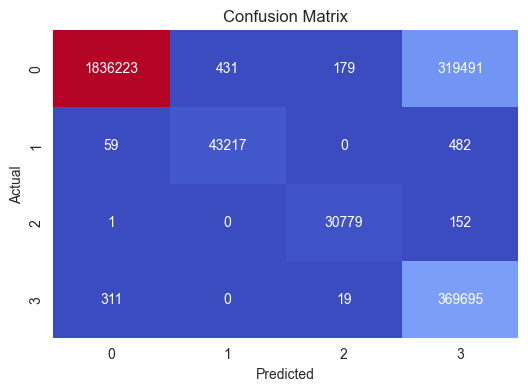

In [13]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()